#Dataset download and save in drive

In [25]:
!wget http://images.cocodataset.org/zips/val2014.zip --verbose

--2022-02-04 13:14:16--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.224.65
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.224.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip’

val2014.zip         100%[===================>]   6.19G  42.5MB/s    in 2m 25s  

2022-02-04 13:16:41 (43.9 MB/s) - ‘val2014.zip’ saved [6645013297/6645013297]



In [26]:
!unzip val2014.zip -d /content/CocoVal2014

Streaming output truncated to the last 5000 lines.
 extracting: /content/CocoVal2014/val2014/COCO_val2014_000000535608.jpg  
 extracting: /content/CocoVal2014/val2014/COCO_val2014_000000279145.jpg  
 extracting: /content/CocoVal2014/val2014/COCO_val2014_000000243495.jpg  
 extracting: /content/CocoVal2014/val2014/COCO_val2014_000000225791.jpg  
 extracting: /content/CocoVal2014/val2014/COCO_val2014_000000428067.jpg  
 extracting: /content/CocoVal2014/val2014/COCO_val2014_000000059383.jpg  
 extracting: /content/CocoVal2014/val2014/COCO_val2014_000000558498.jpg  
 extracting: /content/CocoVal2014/val2014/COCO_val2014_000000376123.jpg  
 extracting: /content/CocoVal2014/val2014/COCO_val2014_000000191304.jpg  
 extracting: /content/CocoVal2014/val2014/COCO_val2014_000000171062.jpg  
 extracting: /content/CocoVal2014/val2014/COCO_val2014_000000014549.jpg  
 extracting: /content/CocoVal2014/val2014/COCO_val2014_000000121152.jpg  
 extracting: /content/CocoVal2014/val2014/COCO_val2014_000000

In [27]:
!rm /content/val2014.zip

# Dataset prepratation

In [28]:
DATASET_PATH = '/content/CocoVal2014'

In [29]:
import os

FINAL_PATH = '/content/CocoVal2014-modified'

if not os.path.exists(FINAL_PATH):
  os.makedirs(FINAL_PATH)

In [30]:
from PIL import Image,ImageChops

def is_greyscale(im):
    if im.mode not in ("L", "RGB"):
        raise ValueError("Unsuported image mode")

    if im.mode == "RGB":
        rgb = im.split()
        if ImageChops.difference(rgb[0],rgb[1]).getextrema()[1]!=0: 
            return False
        if ImageChops.difference(rgb[0],rgb[2]).getextrema()[1]!=0: 
            return False
    return True

In [31]:
import os
from PIL import Image
from tqdm import tqdm

for subdir, dirs, files in os.walk(DATASET_PATH):
    for file in tqdm(files):
        filepath = subdir + os.sep + file
        image = Image.open(filepath)

        if is_greyscale(image):
          continue

        new_image = image.resize((64, 64))
        new_image.save(FINAL_PATH + os.sep + file)

0it [00:00, ?it/s]
100%|██████████| 40504/40504 [08:23<00:00, 80.41it/s]


In [32]:
!rm -rf /content/CocoVal2014/

# Model

In [33]:
FINAL_PATH = '/content/CocoVal2014-modified'

In [34]:
!nvidia-smi

Fri Feb  4 13:27:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    29W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [35]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
from torchvision.utils import save_image

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [37]:
class depthwise_separable_conv(nn.Module):
    def __init__(self, nin, kernels_per_layer, nout):
        super(depthwise_separable_conv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin * kernels_per_layer, kernel_size=5, padding=2, groups=nin)
        self.pointwise = nn.Conv2d(nin * kernels_per_layer, nout, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

In [38]:
def swish(x):
    return x * torch.sigmoid(x)

In [39]:
class ChannelSELayer(nn.Module):
    def __init__(self, num_channels, reduction_ratio=2):
        super(ChannelSELayer, self).__init__()
        num_channels_reduced = num_channels // reduction_ratio
        self.reduction_ratio = reduction_ratio
        self.fc1 = nn.Linear(num_channels, num_channels_reduced, bias=True)
        self.fc2 = nn.Linear(num_channels_reduced, num_channels, bias=True)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_tensor):
        batch_size, num_channels, H, W = input_tensor.size()
        squeeze_tensor = input_tensor.view(batch_size, num_channels, -1).mean(dim=2)

        fc_out_1 = self.relu(self.fc1(squeeze_tensor))
        fc_out_2 = self.sigmoid(self.fc2(fc_out_1))

        a, b = squeeze_tensor.size()
        output_tensor = torch.mul(input_tensor, fc_out_2.view(a, b, 1, 1))
        return output_tensor

In [40]:
class dec_res(nn.Module):
  def __init__(self,in_channel):
    super(dec_res,self).__init__()
    
    self.bn1 = nn.BatchNorm2d(in_channel)
    
    self.c1 = nn.Conv2d(in_channels=in_channel,out_channels=2*in_channel,kernel_size=1,stride=1,padding=0)
    self.bn2 = nn.BatchNorm2d(2*in_channel)

    self.c2 = nn.Conv2d(in_channels=2*in_channel,out_channels=4*in_channel,kernel_size=1,stride=1,padding=0)
    self.bn3 = nn.BatchNorm2d(4*in_channel)

    self.c3 = nn.Conv2d(in_channels=4*in_channel,out_channels=8*in_channel,kernel_size=1,stride=1,padding=0)
    self.bn4 = nn.BatchNorm2d(8*in_channel)

    self.dc1 = depthwise_separable_conv(nin=8*in_channel,kernels_per_layer=3,nout=8*in_channel)

    self.bn5 = nn.BatchNorm2d(8*in_channel)
    self.c4 = nn.Conv2d(in_channels=8*in_channel,out_channels=4*in_channel,kernel_size=1,stride=1,padding=0)

    self.bn6 = nn.BatchNorm2d(4*in_channel)
    self.c5 = nn.Conv2d(in_channels=4*in_channel,out_channels=2*in_channel,kernel_size=1,stride=1,padding=0)

    self.bn7 = nn.BatchNorm2d(2*in_channel)
    self.c6 = nn.Conv2d(in_channels=2*in_channel,out_channels=in_channel,kernel_size=1,stride=1,padding=0)

    self.bn8 = nn.BatchNorm2d(in_channel)

    self.SE = ChannelSELayer(in_channel)

  def forward(self,x1):
    x = self.c1(self.bn1(x1))
    
    x = swish(self.bn2(x))
    x = self.c2(x)
    
    x = swish(self.bn3(x))
    x = self.c3(x)

    x = swish(self.bn4(x))
    x = self.dc1(x)

    x = swish(self.bn5(x))
    x = self.c4(x)

    x = swish(self.bn6(x))
    x = self.c5(x)

    x = swish(self.bn7(x))
    x = self.c6(x)
    
    x = self.bn8(x)
    x = self.SE(x)
    return x+x1

class enc_res(nn.Module):
  def __init__(self,in_channel):
    super(enc_res,self).__init__()

    self.bn1 = nn.BatchNorm2d(in_channel)

    self.c1 = nn.Conv2d(in_channels=in_channel,out_channels=2*in_channel,kernel_size=3,stride=1,padding=1)
    self.bn2 = nn.BatchNorm2d(2*in_channel)

    self.c2 = nn.Conv2d(in_channels=2*in_channel,out_channels=4*in_channel,kernel_size=3,stride=1,padding=1)
    self.bn3 = nn.BatchNorm2d(4*in_channel)

    self.c3 = nn.Conv2d(in_channels=4*in_channel,out_channels=8*in_channel,kernel_size=3,stride=1,padding=1)
    self.bn4 = nn.BatchNorm2d(8*in_channel)

    self.c4 = nn.Conv2d(in_channels=8*in_channel,out_channels=4*in_channel,kernel_size=3,stride=1,padding=1)
    self.bn5 = nn.BatchNorm2d(4*in_channel)

    self.c5 = nn.Conv2d(in_channels=4*in_channel,out_channels=2*in_channel,kernel_size=3,stride=1,padding=1)
    self.bn6 = nn.BatchNorm2d(2*in_channel)

    self.c6 = nn.Conv2d(in_channels=2*in_channel,out_channels=in_channel,kernel_size=3,stride=1,padding=1)
    self.bn7 = nn.BatchNorm2d(in_channel)

    self.SE = ChannelSELayer(in_channel)
  def forward(self,x1):
    x = swish(self.bn1(x1))
    x = self.c1(x)

    x = swish(self.bn2(x))
    x = self.c2(x)

    x = swish(self.bn3(x))
    x = self.c3(x)

    x = swish(self.bn4(x))
    x = self.c4(x)

    x = swish(self.bn5(x))
    x = self.c5(x)

    x = swish(self.bn6(x))
    x = self.c6(x)

    x = swish(self.bn7(x))
    x = self.SE(x)
    return x+x1

In [41]:
class NVAE(nn.Module):
  def __init__(self,start_channel,original_dim):
    super(NVAE,self).__init__()
    self.original_dim = original_dim
    self.conv1 = nn.Conv2d(in_channels=start_channel,out_channels=8,kernel_size=3,stride=1,padding=1)
    self.encblock1 = enc_res(8)
    self.dsconv1 = nn.Conv2d(in_channels=8,out_channels=8,kernel_size=2,stride=2,padding=0)
    self.encblock2 = enc_res(8)
    self.dsconv2 = nn.Conv2d(in_channels=8,out_channels=8,kernel_size=2,stride=2,padding=0)

    self.qmu1 = nn.Linear(original_dim*original_dim*2,original_dim*original_dim*2)
    self.qvar1 = nn.Linear(original_dim*original_dim*2,original_dim*original_dim*2)
    
    self.qmu0 = nn.Linear(original_dim*original_dim//2,original_dim*original_dim//2)
    self.qvar0 = nn.Linear(original_dim*original_dim//2,original_dim*original_dim//2)

    self.pmu1 = nn.Linear(original_dim*original_dim*2,original_dim*original_dim*2)
    self.pvar1 = nn.Linear(original_dim*original_dim*2,original_dim*original_dim*2)

    self.decblock1 = dec_res(8)
    self.usconv1 = nn.ConvTranspose2d(in_channels=8,out_channels=8,kernel_size=2,stride=2,padding=0)
    self.decblock2 = dec_res(16)
    self.usconv2 = nn.ConvTranspose2d(in_channels=16,out_channels=16,kernel_size=2,stride=2,padding=0)
    self.decblock3 = dec_res(16)
    self.finconv = nn.Conv2d(in_channels=16,out_channels=start_channel,kernel_size=3,stride=1,padding=1)
  
  def forward(self,x):
    z1 = self.dsconv1(self.encblock1(self.conv1(x)))
    z0 = self.dsconv2(self.encblock2(z1))

    qmu0 = self.qmu0(z0.reshape(z0.shape[0],self.original_dim*self.original_dim//2))
    qvar0 = self.qvar0(z0.reshape(z0.shape[0],self.original_dim*self.original_dim//2))

    qmu1 = self.qmu1(z1.reshape(z1.shape[0],self.original_dim*self.original_dim*2))
    qvar1 = self.qvar1(z1.reshape(z1.shape[0],self.original_dim*self.original_dim*2))

    stdvar0 = qvar0.mul(0.5).exp_()
    stdvar1 = qvar1.mul(0.5).exp_()

    e0 = torch.randn(qmu0.shape).to(device)
    ez0 = qmu0+e0*stdvar0
    ez0 = ez0.reshape(ez0.shape[0],8,self.original_dim//4,self.original_dim//4)
    ez1 = self.usconv1(self.decblock1(ez0))

    pmu1 = self.pmu1(ez1.reshape(ez1.shape[0],self.original_dim*self.original_dim*2))
    pvar1 = self.pvar1(ez1.reshape(ez1.shape[0],self.original_dim*self.original_dim*2))

    pstdvar1 = pvar1.mul(0.5).exp_()

    e2 = torch.randn(qmu1.shape).to(device)
    ez2 = pmu1+qmu1 + e2*pstdvar1*stdvar1
    ez2 = ez2.reshape(ez2.shape[0],8,self.original_dim//2,self.original_dim//2)
    
    final = torch.cat((ez1,ez2),1)

    recons = nn.Sigmoid()(self.finconv(self.decblock3(self.usconv2(self.decblock2(final)))))

    return qmu0,qvar0,qmu1,qvar1,pmu1,pvar1,recons

  def sample(self,bs):
    e = torch.randn([bs,8,self.original_dim//4,self.original_dim//4]).to(device)
    ez1 = self.usconv1(self.decblock1(e))

    pmu1 = self.pmu1(ez1.reshape(ez1.shape[0],self.original_dim*self.original_dim*2))
    pvar1 = self.pvar1(ez1.reshape(ez1.shape[0],self.original_dim*self.original_dim*2))

    stdvar1 = pvar1.mul(0.5).exp_()

    e1 = torch.randn([ez1.shape[0],self.original_dim*self.original_dim*2]).to(device)
    e1 = pmu1 + e1*stdvar1
    e1 = e1.reshape(e1.shape[0],8,self.original_dim//2,self.original_dim//2)
    recons = nn.Sigmoid()(self.finconv(self.decblock3(self.usconv2(self.decblock2(torch.cat((ez1,e1),1))))))

    return recons

  def loss(self,x):
    qmu0,qvar0,qmu1,qvar1,pmu1,pvar1,recons = self.forward(x)
    klz0 = 0.5*torch.sum(torch.square(qmu0)+qvar0.exp()-qvar0-1)/x.shape[0]
    klz1 = 0.5*torch.sum(torch.square(qmu1)/pvar1.exp()+qvar1.exp()-qvar1-1)
    reconsloss = nn.BCELoss()(recons,x)
    return klz0,klz1,reconsloss

In [42]:
batch_size=64

In [43]:
transform = transforms.Compose([transforms.ToTensor()])

In [44]:
from os import listdir
from PIL import Image

class CocoDataloader(object):
    def __init__(self, data_dir, transform=None):
        self.transform = transform
        self.image_names = [os.path.join(data_dir, img) for img in listdir(data_dir) if os.path.join(data_dir, img)]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):

        image = Image.open(self.image_names[idx])

        if self.transform:
            image = self.transform(image)

        return image, self.image_names[idx]

In [45]:
from torch.utils.data import DataLoader

train = CocoDataloader(FINAL_PATH, transform=transforms.Compose([transforms.ToTensor()]))
loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2)

In [46]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [47]:
model = NVAE(3,64).to(device)
optim = torch.optim.Adamax(model.parameters())

In [48]:
epochs = 20

epoch: 0 kl0_loss: 963.5835656842404 recons_loss: 0.6501601996483125 kl1_loss: 3038.7232349230358


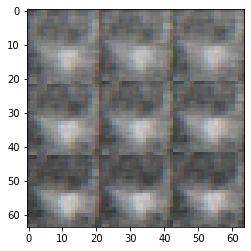

epoch: 1 kl0_loss: 465.9038655825793 recons_loss: 0.6587181613431946 kl1_loss: 327.8573395242126


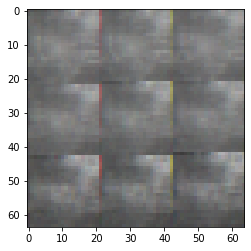

epoch: 2 kl0_loss: 123.5970041058312 recons_loss: 0.6635442847162677 kl1_loss: 83.97694981695292


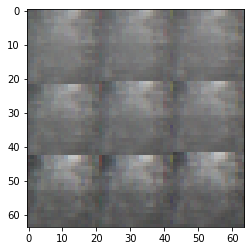

epoch: 3 kl0_loss: 44.76045157392897 recons_loss: 0.6624061902767403 kl1_loss: 44.82434806924145


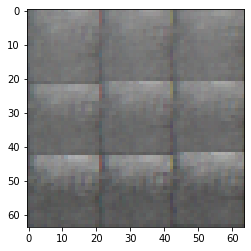

epoch: 4 kl0_loss: 19.48214734579117 recons_loss: 0.6606036449016376 kl1_loss: 25.21063057321294


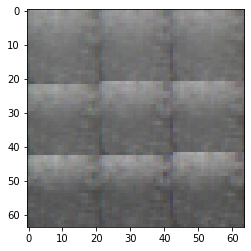

epoch: 5 kl0_loss: 8.356630467744559 recons_loss: 0.6599898140566046 kl1_loss: 15.938189388778813


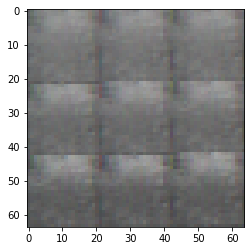

epoch: 6 kl0_loss: 3.6024495308170312 recons_loss: 0.659574749089038 kl1_loss: 11.690020283620441


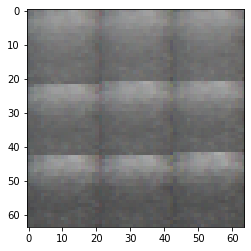

epoch: 7 kl0_loss: 2.2096378210058045 recons_loss: 0.6576585606554832 kl1_loss: 3.812095620020028


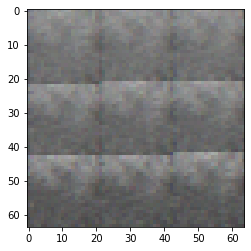

epoch: 8 kl0_loss: 1.8912941105361107 recons_loss: 0.6580889411111269 kl1_loss: 4.027311656212504


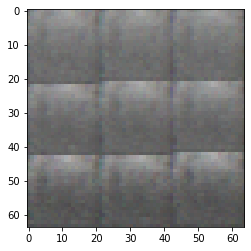

epoch: 9 kl0_loss: 1.63031234509545 recons_loss: 0.6589858487763997 kl1_loss: 3.6283480923756457


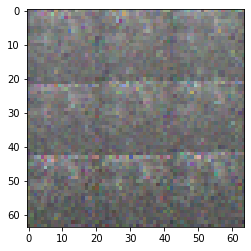

epoch: 10 kl0_loss: 1.4086034955406077 recons_loss: 0.6591940454773028 kl1_loss: 2.646251427056611


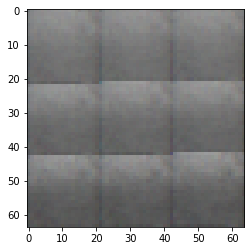

epoch: 11 kl0_loss: 1.2089175111494537 recons_loss: 0.6595562630031727 kl1_loss: 1.2920909347876097


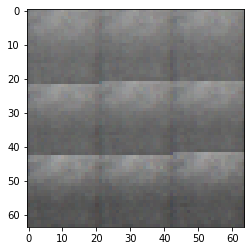

epoch: 12 kl0_loss: 1.1372300396506512 recons_loss: 0.6589026084829444 kl1_loss: 2.0803515838499256


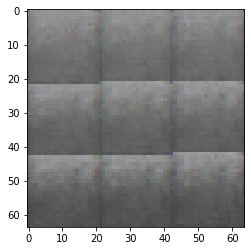

KeyboardInterrupt: ignored

In [77]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.image as mpimg

for epoch in range(epochs):
    minloss = 1
    running_kl0_loss=0
    running_recons_loss=0
    running_kl1_loss=0
    num_images=0
    for i, (img, image_name) in enumerate(loader):
      img = img.to(device)
      optim.zero_grad()
      klz0,klz1,recons = model.loss(img)
      loss=recons+epoch*0.001*klz0+epoch*0.001*klz1
      loss.backward()
      optim.step()
      running_kl0_loss = running_kl0_loss + klz0.item()*len(img)
      running_kl1_loss = running_kl1_loss + klz1.item()*len(img)
      running_recons_loss = running_recons_loss + recons.item()*len(img)

      num_images= num_images+len(img)
    print('epoch: '+str(epoch)+' kl0_loss: '+str(running_kl0_loss/num_images)+' recons_loss: '+str(running_recons_loss/num_images)+' kl1_loss: '+str(running_kl1_loss/num_images))
    img = model.sample(1).cpu().detach().reshape(64, 64, 3).numpy()
    plt.imshow(img)
    plt.savefig(str(epoch)+".png")
    plt.show()